In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import time
import random
import datetime
import os
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import Tensor
import functools
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
import torchvision
from model.drn import drn_d_54, drn_d_base
from model.CBAM import drn_d_CBAM
from model.resnet import ResNet50 as resnet
from model.efficientnet import *
from load_data import *
from optimizer import Ranger
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score,accuracy_score, precision_score,f1_score

In [3]:
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
test_size = 0.2
valid_size = 0.3
train_size = 0.5
batch_size = 4
test_bs = 4
random.seed(time.time())

In [5]:
class Focal_Loss(_Loss):
    def __init__(self, alpha = 1 , gamma = 1 , logits = False, reduce = False, ignore_index=10000, from_logits=False):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.logits = logits
        self.reduce = reduce
        self.loss  = nn.BCELoss(weight = torch.Tensor([3.0, 1.0]).to(device))
    def forward(self, inputs, targets):
        #CE = F.cross_entropy(inputs, targets, weight = torch.Tensor([1.0, 4.0]).to(device), ignore_index=self.ignore_index)
        inputs = torch.sigmoid(inputs)
        #print(inputs.shape, targets.shape)
        CE = self.loss(inputs, targets)
        pt = torch.exp(-CE)
        F_loss = self.alpha * (1-pt)**self.gamma * CE

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

class Hswish(nn.Module):
    def forward(self, x):
        swish = F.relu6(x + 3 , inplace = True)
        return x* swish/6.

class conv_set(nn.Module):
    """docstring for conv_set"""
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding):
        super(conv_set, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_ch),
            Hswish()
            )
    def forward(self, x):
        out = self.conv(x)
        return out

class A_net(nn.Module):

    def __init__(self, classes):
        super(A_net, self).__init__()
        self.classes = classes
        self.conv  = nn.Conv2d(1, 3, 1, 1, 0)
        self.conv1 = conv_set(3,12,3,1,0)
        self.conv2 = conv_set(12,16,3,1,0)
        self.conv3 = conv_set(16,32,3,1,0)
        self.conv4 = conv_set(32,classes,3,1,2)
        #self.conv5 = conv_set(64,classes,3,1,0)
    def forward(self, x):
        x = self.conv(x)
        out = self.conv1(x)
        out = F.max_pool2d(out, 2,2)
        out = self.conv2(out)
        out = F.max_pool2d(out, 2,2)
        out = self.conv3(out)
        out = F.max_pool2d(out, 2,2)
        out = self.conv4(out)
        return out 
    
class CNNX1(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX1, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model = drn_d_CBAM(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = self._dropout(x)

        return x

class EFFN(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(EFFN, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        self.model = efficientnet_el()
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)
        #x = self._dropout(x)

        return x
    
class CNNX(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model = resnet()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self._dropout(x)

        return x

def save_model(state,save_model_path,modelname):
    filename = os.path.join(save_model_path,modelname+'_'+str(state['epoch']+1)+'.pth')
    torch.save(state,filename)

def save_best(state,save_model_path,modelname):
    filename = os.path.join(save_model_path,modelname+'_'+'.pth')
    torch.save(state,filename)

def load_model(Net, optimizer, model_file):
    assert os.path.exists(model_file),'There is no model file from'+model_file
    checkpoint = torch.load(model_file)
    print('load', model_file)
    Net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']+1
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return Net, optimizer, start_epoch

def train(model, data_loader, opt, loss, epoch,verbose = True):
    model.train()
    loss_avg = 0.0
    correct = 0
    for batch_idx, (data,target) in enumerate(data_loader):
        #print(data.shape)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss_avg = loss_avg + loss.item()
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = target[:,1].long()
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        verbose_step = len(data_loader) 
        if (batch_idx+1)  % verbose_step == 0 and verbose:
            print('Train Epoch: {}  Step [{}/{} ({:.0f}%)]  Loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                epoch, batch_idx * len(data), len(train_idx),
                100. * batch_idx / len(train_idx), loss.item(), correct, len(train_idx),
            100. * correct / (len(train_idx))))
    return loss_avg / (len(train_idx))

def test(model, data_loader, loss):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        correct_pe = 0
        correct_noPE = 0
        y = []
        y_score = []
        y_pred = []
        y_score = []
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            #print(target.shape)
            output = model(data)
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            #print(pred)
            target = target[:,1].long()
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            score = F.softmax(output, dim = 1)
            for i in range(target.shape[0]):
                y.append(target[i].cpu().numpy())
                y_score.append(score[i,1].cpu().numpy())
                y_pred.append(pred[i].cpu().numpy())
                if target[i] == 1:
                    correct_pe += pred[i].eq(target[i].data.view_as(pred[i])).cpu().sum().item()
    
                if target[i] == 0:
                    correct_noPE += pred[i].eq(target[i].data.view_as(pred[i])).cpu().sum().item()

        test_loss /= len(data_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), PE_acc: ({}), noPE_acc: ({})\n'.format(
            test_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset), correct_pe, correct_noPE))   
    #return float(correct) / len(data_loader.dataset),y, y_score, y_pred
    return float(correct) / len(data_loader.dataset)


#net = EFFN().to(device)

class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    Reference:
    Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Code imported from https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py.
    Args:
        margin (float): margin for triplet.
    """

    def __init__(self, margin=0.6, mutual_flag=False):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        self.mutual = mutual_flag

    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (num_classes)
        """
        n = inputs.size(0)
        # inputs = 1. * inputs / (torch.norm(inputs, 2, dim=-1, keepdim=True).expand_as(inputs) + 1e-12)
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        # For each anchor, find the hardest positive and negative
        targets = targets[:,1]
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        if self.mutual:
            return loss, dist
        return loss

class remix_loss(nn.Module):
    """docstring for remix_loss"""
    def __init__(self):
        super(remix_loss, self).__init__()
        self.loss1 = Focal_Loss()
        self.loss2 = TripletLoss()
    def forward(self, inputs, targets):
        loss = self.loss1(inputs, targets) + self.loss2(inputs, np.argmax(targets))

        return loss 

## Data process

In [6]:
import glob

folder_name =list(glob.glob('/home/ubuntu/Andrew/lung_datatset/'))
print(folder_name)
num_pic_1 = len(list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE/*'))+list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE_new/*')))
num_pic_0 = len(list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*')))
print(num_pic_0,num_pic_1)

['/home/ubuntu/Andrew/lung_datatset/']
655 238


In [7]:
CT_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
CT_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE/*') + list(glob.glob('/home/ubuntu/Andrew/lung_datatset/PE_new/*')))
#CT_1_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
#CT_1.append(CT_1_1)
num_0 = len(CT_0)
num_1 = len(CT_1)
print(num_0,num_1)
random.shuffle (CT_1)
split_t_0 = int(train_size*num_pic_0)
split_t_1 = int(train_size*num_pic_1)
split_v_0 = int(valid_size*num_pic_0)
split_v_1 = int(valid_size*num_pic_1)
split_te_0 = int(test_size*num_pic_0)
split_te_0 = int(test_size*num_pic_1)
print(split_t_0,split_t_1,split_v_0,split_v_1)
train_0 = CT_0[0:split_t_0]
train_1 = CT_1[0:split_t_1]
valid_0 = CT_0[split_t_0:split_t_0+split_v_0]
valid_1 = CT_1[split_t_1:split_t_1+split_v_1]
test_0 = CT_0[split_t_0+split_v_0:]
test_1 = CT_1[split_t_1+split_v_1:]
#test_0 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v0/*'))
#test_1 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v1/*'))
print(len(train_0),len(train_1),len(valid_0),len(valid_1),len(test_0),len(test_1))

655 238
327 119 196 71
327 119 196 71 132 48


In [8]:
def get_data(folder0, folder1, repeat):
    class0_path = []
    class1_path = []
    target0 = []
    target1 = []
    for x in folder0:
        #print(x)
        class0 = x
        #print(class0)
        class0_path.append(class0)
        target0.append(torch.tensor([1.0,0.0]).long())
    for x in folder1:
        #class1 = glob.glob(x + '/*dcm')
        class1 = x
        class1_path.append(class1)
        target1.append(torch.tensor([0.0,1.0]).long())

    #class0_path = random.sample(class0_path, k = len(class1_path))
    #target0 = random.sample(target0, k = len(target1))
    print(len(class0_path), len(class1_path))
    file_path = class0_path + class1_path
    target = target0 + target1
    #print(file_path, target)
    data = zip(file_path, target)
    return data, len(class0_path), len(class1_path)

In [189]:
train_data, _, _ = get_data(train_0, train_1, 1)
valid_data,pe0, pe1 = get_data(valid_0, valid_1, 1)
test_data, _, _ = get_data(test_0, test_1, 1)

327 119
196 71
132 48


In [190]:
print(type(train_data))

<class 'zip'>


In [191]:
from load_data import *

Train_Set = PE_transform(list(train_data), transform = None)
Valid_Set = PE_transform(list(valid_data), transform = None)
Test_Set = PE_transform(list(test_data), transform = None)

In [192]:
num_train = len(list(Train_Set))
num_valid = len(list(Valid_Set))
indices = list(range(num_train))
v_indices = list(range(num_valid))
train_idx, valid_idx = indices, v_indices

In [193]:
train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
                        num_workers=8, pin_memory=True)
valid_loader = DataLoader(Valid_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)
test_loader = DataLoader(Test_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

In [26]:
net = CNNX1().to(device)
learning_rate = 0.0001
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer = Ranger(net.parameters())

# Train the model
num_epochs = 250
model_name = 'dinamic_cut_drn'
#model_name = 'EFF_0608_r'
#loss_fn = nn.BCELoss()
loss_fn = Focal_Loss()
output_path = 'log'
resume = 'None'

#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth'
#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_.pth'
StartTime = time.time()
loss, val_acc, lr_curve = [], [], []
'''
if resume is not None:
    net, optimizer, _ = load_model(net, optimizer, resume)
    #print('load', resume)
'''

best_acc = 0.0
best = 0
for epoch in range(num_epochs):

    
    #if (epoch+1)%5 == 0:
    #    random.seed(epoch)
    #    train_data = get_train_data(train_folder)
    #    Train_Set = PE(list(train_data), transform = None)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=8, pin_memory=True)
    #    class0_path = random.sample(class0_path, k = 3*len(class1_path))
    #    target0 = random.sample(target0, k = 3*len(target1))
    #    print(len(class0_path), len(class1_path))
    #    file_path = class0_path + class1_path
    #    target = target0 + target1
    #    #print(file_path, target)
    #    train_data = zip(file_path, target)
    #    Train_Set = PE(list(train_data), transform = True)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=4, pin_memory=True)
    #lr = adjust_learning_rate(learning_rate, optimizer, epoch, epoch_list=[80, 170])
    train_loss = train(net, train_loader, optimizer, loss_fn, epoch, verbose=True)
    valid_acc = test(net, valid_loader, loss_fn)
    #valid_acc, tp, tn = test(net, valid_loader, loss_fn)
    loss.append(train_loss)
    #print((tn/pe0), tp/pe1)
    val_acc.append(valid_acc)
    if (epoch+1)%10 == 0 or epoch==num_epochs-1:
        save_model({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),model_name)
    
    #if tp/pe1 > 0.7 and tn>best:
    if valid_acc >= best_acc:
        #print((tn//pe0), tp//pe1)
        print(valid_acc)
        save_best({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),'CT_class_dinamic_cut_drn')
        best_acc = valid_acc
        #best = tn


/home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0  Step [222/446 (25%)]  Loss: 3.659688, Accuracy: 319/446 (72%)


Test set: Average loss: 0.1790, Accuracy: 196/267 (73%), PE_acc: (0), noPE_acc: (196)

0.7340823970037453
Train Epoch: 1  Step [222/446 (25%)]  Loss: 0.212487, Accuracy: 330/446 (74%)


Test set: Average loss: 0.1751, Accuracy: 200/267 (75%), PE_acc: (4), noPE_acc: (196)

0.7490636704119851
Train Epoch: 2  Step [222/446 (25%)]  Loss: 0.023451, Accuracy: 334/446 (75%)


Test set: Average loss: 0.1315, Accuracy: 208/267 (78%), PE_acc: (12), noPE_acc: (196)

0.7790262172284644
Train Epoch: 3  Step [222/446 (25%)]  Loss: 0.202240, Accuracy: 352/446 (79%)


Test set: Average loss: 0.1122, Accuracy: 225/267 (84%), PE_acc: (38), noPE_acc: (187)

0.8426966292134831
Train Epoch: 4  Step [222/446 (25%)]  Loss: 0.143727, Accuracy: 391/446 (88%)


Test set: Average loss: 0.1748, Accuracy: 216/267 (81%), PE_acc: (21), noPE_acc: (195)

Train Epoch: 5  Step [222/446 (25%)]  Loss: 0.520415, Accuracy: 401/446 (90%)


Test s

KeyboardInterrupt: 

In [9]:
class PE_lungcrop(Dataset):
    def __init__(self, file, transform=None):
        self.data = file
        self.transform = transform

    def __getitem__(self, index):

        data = self.data[index]
        path, target = data
        image = pydicom.dcmread(path).pixel_array.astype(np.int16)
        image = crop_center(image, 400, 400)
        img = image.copy()
        top_line,bottom_line, left_line,right_line = edgecut(image)
        
        Lung_view = img - 600
        Lung_view[Lung_view>1900] = 1900
        Lung_view[Lung_view<0] = 0
        Lung_view = (Lung_view/950)-1
        Lung_view = Lung_view[top_line:400-bottom_line, left_line:400-right_line]
        Lung_view = cv2.copyMakeBorder(Lung_view,top_line,bottom_line, left_line,right_line,cv2.BORDER_CONSTANT,value=0)
        
        
        
        #print(img[1])
        #if self.transform is not None and target[1] == 1:

        img_tensor = torch.tensor(Lung_view, dtype = torch.float64)
        img_tensor = img_tensor.unsqueeze(0)

        return img_tensor.float(), target.float()

    def __len__(self):
        return len(self.data)  

class PE_Mcrop(Dataset):
    def __init__(self, file, transform=None):
        self.data = file
        self.transform = transform

    def __getitem__(self, index):

        data = self.data[index]
        path, target = data
        image = pydicom.dcmread(path).pixel_array.astype(np.int16)
        image = crop_center(image, 400, 400)
        img = image.copy()
        top_line,bottom_line, left_line,right_line = edgecut(image)
        
        
        #L40 W400 defult
        img = img - 950
        img[img>350] = 350
        img[img<0] = 0
        img = (img/175)-1
        
        img = img[top_line:400-bottom_line, left_line:400-right_line]
        img = cv2.copyMakeBorder(img,top_line,bottom_line, left_line,right_line,cv2.BORDER_CONSTANT,value=0)
        
        #print(img[1])
        #if self.transform is not None and target[1] == 1:

        img_tensor = torch.tensor(img, dtype = torch.float64)
        img_tensor = img_tensor.unsqueeze(0)

        return img_tensor.float(), target.float()

    def __len__(self):
        return len(self.data)  

In [87]:
net = CNNX1().to(device)
learning_rate = 0.0001
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth')
print('test model ready')

from load_data import *

testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/19743272/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/*'))
#testing_1 = list([])
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_dinamic(list(testing_data), transform = None)

print('testing set ready')
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)
test_acc = test(net, testing_loader, loss_fn)



load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth
set state called
test model ready
13 27
testing set ready

Test set: Average loss: 0.0323, Accuracy: 39/40 (98%), PE_acc: (26), noPE_acc: (13)



In [88]:
for data, target in testing_loader:
    
    data,  target = data.to(device), target.to(device)

['/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049436.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049444.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049441.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049431.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049432.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049427.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049438.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049437.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049434.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049433.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049426.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049428.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049442.dcm', '/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/0409049430.dcm', '/home/ubuntu/Andrew/lung_datatse

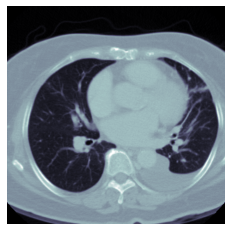

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


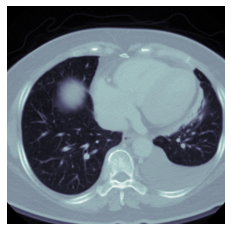

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


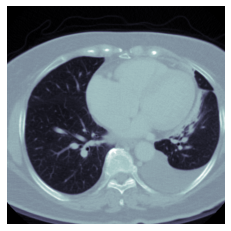

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


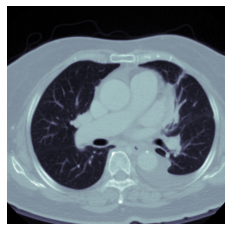

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


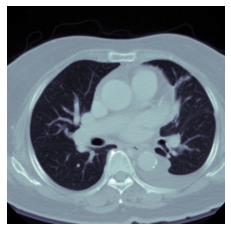

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


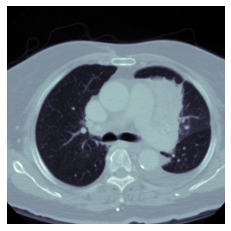

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


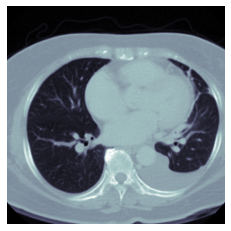

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


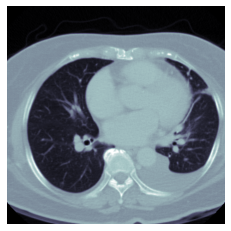

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


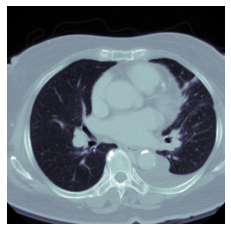

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


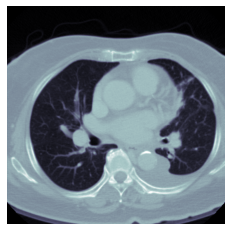

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


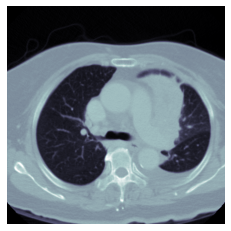

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


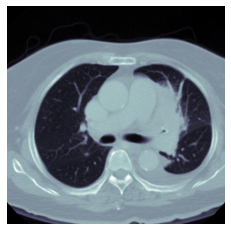

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


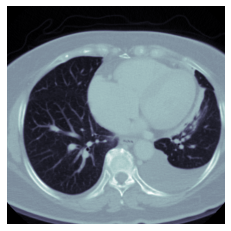

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


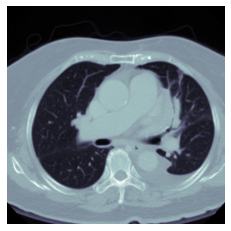

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


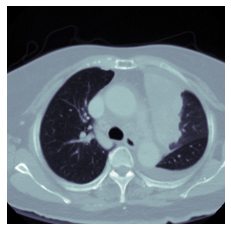

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


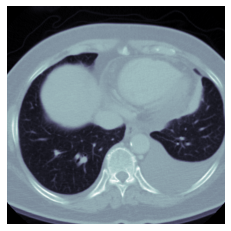

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


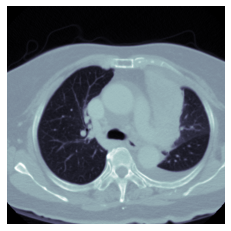

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


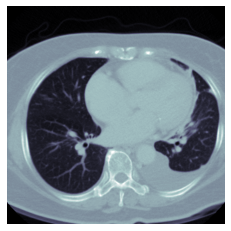

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


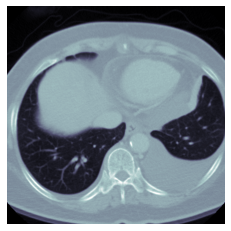

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


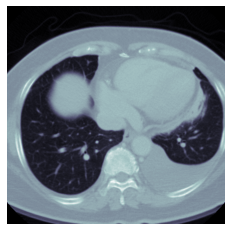

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


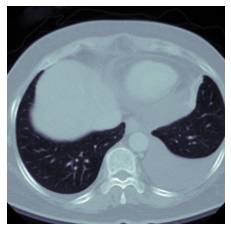

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


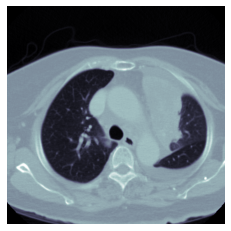

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


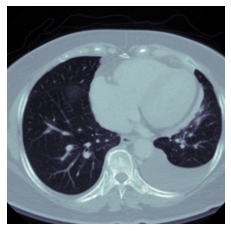

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


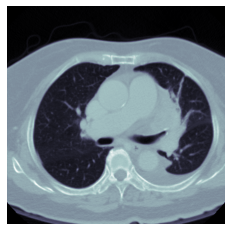

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


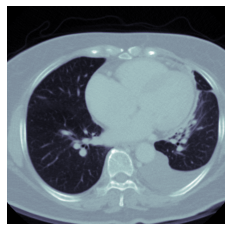

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


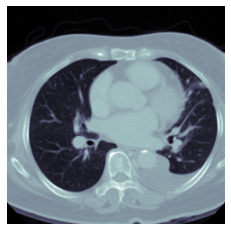

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


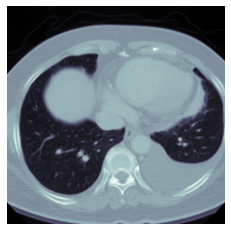

In [89]:
paths = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/PE/04090494/*'))
print(paths)
for path in paths:
    image = pydicom.dcmread(path).pixel_array.astype(np.int16)
    image = crop_center(image, 400, 400)
    img = image.copy()
    top_line,bottom_line, left_line,right_line = edgecut(image)
    img[img>1624] = 1624
    img = (img/812)-1
    #Lung_view = img - 600
    #Lung_view[Lung_view>1900] = 1900
    #Lung_view[Lung_view<0] = 0
    #img = img - 950
    #img[img>350] = 350
    #img[img<0] = 0
    #img = (img/175)-1
    #img = (Lung_view/950)-1
    img_tensor = torch.tensor(img, dtype = torch.float64)
    img_tensor = img_tensor.unsqueeze(0)
    #img = img[top_line:400-bottom_line, left_line:400-right_line]
    #img = cv2.copyMakeBorder(img,top_line,bottom_line, left_line,right_line,cv2.BORDER_CONSTANT,value=0)
    
    new_img = np.zeros((400,400,3))
    for ch in range(3):
        for xx in range(400):
            for yy in range(400):
                new_img[xx,yy,ch] = img[xx,yy]
    rgb_img = new_img
    print(img)
    
    plt.imshow(img ,plt.cm.bone)
    plt.axis('off')
    plt.show()

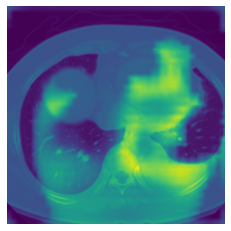

In [90]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = net.to(device)
target_layer = model.model.layer8[-1]
input_tensor = data# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layer=target_layer)

# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = 1

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor,  target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
'''
new_gimg = np.zeros((400,400,3))
for ch in range(3):
    for xx in range(400):
        for yy in range(400):
            new_gimg[xx,yy,ch] = grayscale_cam[xx,yy]'''

plt.imshow(grayscale_cam * 3 + img  )
plt.axis('off')
plt.show()
visualization = show_cam_on_image(rgb_img, grayscale_cam)

# dinamic crop drn

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth
set state called

Test set: Average loss: 0.0213, Accuracy: 176/180 (98%), PE_acc: (46), noPE_acc: (130)

Time Usage:  0:24:56


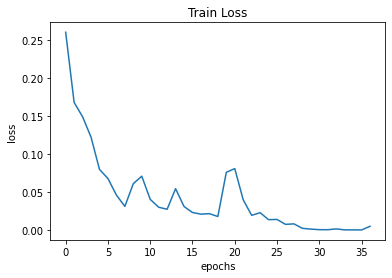

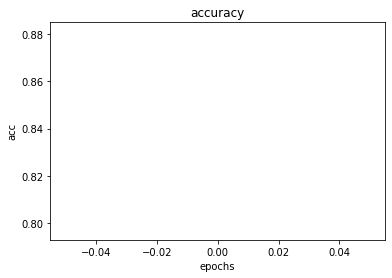

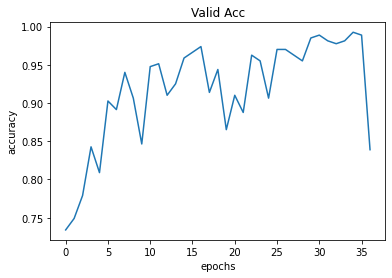

In [28]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth
set state called

Test set: Average loss: 0.3847, Accuracy: 131/180 (73%), PE_acc: (9), noPE_acc: (122)

Time Usage:  0:19:01


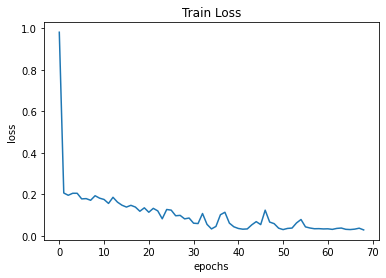

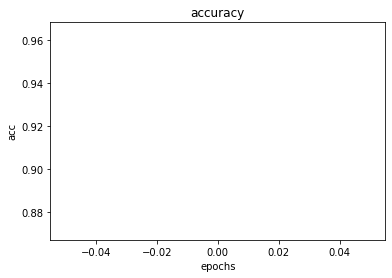

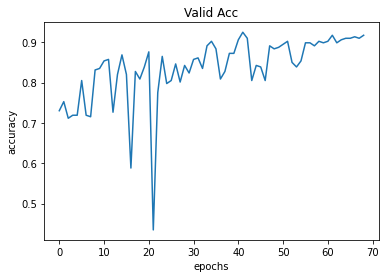

In [205]:
net = CNNX1().to(device)
learning_rate = 0.0001
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Canny edge drn

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_canny_drn_.pth
set state called

Test set: Average loss: 0.2019, Accuracy: 132/166 (80%), PE_acc: (0), noPE_acc: (132)

Time Usage:  0:36:22


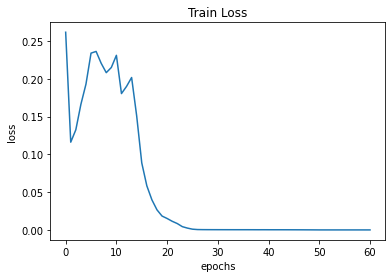

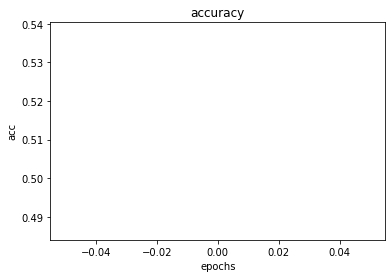

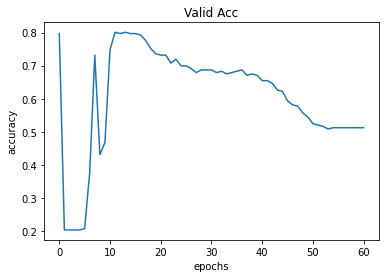

In [59]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_canny_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## ResNet 50 (50epoch) 

In [196]:
net = CNNX()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_.pth')
test_acc = test(net, test_loader, loss_fn)
'''
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_A1_.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_10.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_20.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_30.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_40.pth')
test_acc = test(net, test_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_50.pth')
test_acc = test(net, test_loader, loss_fn)
#test_acc, y, y_score, y_pred = test(net, test_loader, loss_fn)

y = np.array(y)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
print('precision', precision, 'recall', recall)
ftr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(ftr, tpr)
print('auc', roc_auc)
'''
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.figure()

plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_.pth


RuntimeError: Error(s) in loading state_dict for CNNX:
	Unexpected key(s) in state_dict: "attention.conv.weight", "attention.conv.bias", "attention.conv1.conv.0.weight", "attention.conv1.conv.1.weight", "attention.conv1.conv.1.bias", "attention.conv1.conv.1.running_mean", "attention.conv1.conv.1.running_var", "attention.conv1.conv.1.num_batches_tracked", "attention.conv2.conv.0.weight", "attention.conv2.conv.1.weight", "attention.conv2.conv.1.bias", "attention.conv2.conv.1.running_mean", "attention.conv2.conv.1.running_var", "attention.conv2.conv.1.num_batches_tracked", "attention.conv3.conv.0.weight", "attention.conv3.conv.1.weight", "attention.conv3.conv.1.bias", "attention.conv3.conv.1.running_mean", "attention.conv3.conv.1.running_var", "attention.conv3.conv.1.num_batches_tracked", "attention.conv4.conv.0.weight", "attention.conv4.conv.1.weight", "attention.conv4.conv.1.bias", "attention.conv4.conv.1.running_mean", "attention.conv4.conv.1.running_var", "attention.conv4.conv.1.num_batches_tracked", "conv_out.weight", "conv_out.bias". 

## ResNet 50 (250 epoch)

In [199]:
class CNNX_R(nn.Module):
    
    def __init__(self, backbone = 'drn', out_stride = 16, num_class = 2):
        super(CNNX_R, self).__init__()
        
        if backbone == 'drn':
            output_stride = 8
        #self.drn = drn_d_base(nn.BatchNorm2d)
        #self.drn = gc_drn_54(nn.BatchNorm2d)
        #self.model = mixnet_l()
        self.model = resnet()
        #self.model = drn_d_CBAM(nn.BatchNorm2d)
        #self.attention = A_net(512)
        #self.conv_out = nn.Conv2d(512,2,1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(0.25)
        #self.fc = nn.Linear(2048, 2)
        self.fc = nn.Linear(2048, 2)
        


    def forward(self, input):
        x = self.model(input)
       #atten = self.attention(input)
       #atten = torch.sigmoid(atten)
       #x = torch.mul(x, atten)
        #x = self.conv_out(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self._dropout(x)

        return x


In [201]:
net = CNNX_R().to(device)
learning_rate = 0.0001
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer = Ranger(net.parameters())

# Train the model
num_epochs = 250
model_name = 'fix_cut_r50'
#model_name = 'EFF_0608_r'
#loss_fn = nn.BCELoss()
loss_fn = Focal_Loss()
output_path = 'log'
resume = 'None'

#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth'
#resume = '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_.pth'
StartTime = time.time()
loss, val_acc, lr_curve = [], [], []
'''
if resume is not None:
    net, optimizer, _ = load_model(net, optimizer, resume)
    #print('load', resume)
'''

best_acc = 0.0
best = 0
for epoch in range(num_epochs):

    
    #if (epoch+1)%5 == 0:
    #    random.seed(epoch)
    #    train_data = get_train_data(train_folder)
    #    Train_Set = PE(list(train_data), transform = None)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=8, pin_memory=True)
    #    class0_path = random.sample(class0_path, k = 3*len(class1_path))
    #    target0 = random.sample(target0, k = 3*len(target1))
    #    print(len(class0_path), len(class1_path))
    #    file_path = class0_path + class1_path
    #    target = target0 + target1
    #    #print(file_path, target)
    #    train_data = zip(file_path, target)
    #    Train_Set = PE(list(train_data), transform = True)
    #    train_loader = DataLoader(Train_Set, batch_size=batch_size, shuffle = True,
    #                    num_workers=4, pin_memory=True)
    #lr = adjust_learning_rate(learning_rate, optimizer, epoch, epoch_list=[80, 170])
    train_loss = train(net, train_loader, optimizer, loss_fn, epoch, verbose=True)
    valid_acc = test(net, valid_loader, loss_fn)
    #valid_acc, tp, tn = test(net, valid_loader, loss_fn)
    loss.append(train_loss)
    #print((tn/pe0), tp/pe1)
    val_acc.append(valid_acc)
    if (epoch+1)%10 == 0 or epoch==num_epochs-1:
        save_model({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),model_name)
    
    #if tp/pe1 > 0.7 and tn>best:
    if valid_acc >= best_acc:
        #print((tn//pe0), tp//pe1)
        print(valid_acc)
        save_best({'epoch':epoch,
                    'model_state_dict':net.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    },
                    os.path.join(output_path,'savemodel'),'CT_class_fix_cut_r50')
        best_acc = valid_acc
        #best = tn

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


Train Epoch: 0  Step [222/446 (25%)]  Loss: 0.561826, Accuracy: 308/446 (69%)


Test set: Average loss: 0.2073, Accuracy: 195/267 (73%), PE_acc: (4), noPE_acc: (191)

0.7303370786516854
Train Epoch: 1  Step [222/446 (25%)]  Loss: 3.032319, Accuracy: 318/446 (71%)


Test set: Average loss: 0.1918, Accuracy: 201/267 (75%), PE_acc: (37), noPE_acc: (164)

0.7528089887640449
Train Epoch: 2  Step [222/446 (25%)]  Loss: 0.793628, Accuracy: 331/446 (74%)


Test set: Average loss: 0.1789, Accuracy: 190/267 (71%), PE_acc: (36), noPE_acc: (154)

Train Epoch: 3  Step [222/446 (25%)]  Loss: 0.765151, Accuracy: 329/446 (74%)


Test set: Average loss: 0.1912, Accuracy: 192/267 (72%), PE_acc: (30), noPE_acc: (162)

Train Epoch: 4  Step [222/446 (25%)]  Loss: 0.571939, Accuracy: 328/446 (74%)


Test set: Average loss: 0.1918, Accuracy: 192/267 (72%), PE_acc: (21), noPE_acc: (171)

Train Epoch: 5  Step [222/446 (25%)]  Loss: 0.048580, Accuracy: 351/446 (79%)


Test set: Average loss: 0.1537, Accuracy: 2


Test set: Average loss: 0.0957, Accuracy: 238/267 (89%), PE_acc: (54), noPE_acc: (184)

Train Epoch: 48  Step [222/446 (25%)]  Loss: 0.106316, Accuracy: 423/446 (95%)


Test set: Average loss: 0.1095, Accuracy: 236/267 (88%), PE_acc: (43), noPE_acc: (193)

Train Epoch: 49  Step [222/446 (25%)]  Loss: 0.000063, Accuracy: 436/446 (98%)


Test set: Average loss: 0.1036, Accuracy: 237/267 (89%), PE_acc: (44), noPE_acc: (193)

Train Epoch: 50  Step [222/446 (25%)]  Loss: 0.102043, Accuracy: 440/446 (99%)


Test set: Average loss: 0.0955, Accuracy: 239/267 (90%), PE_acc: (48), noPE_acc: (191)

Train Epoch: 51  Step [222/446 (25%)]  Loss: 0.210927, Accuracy: 440/446 (99%)


Test set: Average loss: 0.0923, Accuracy: 241/267 (90%), PE_acc: (50), noPE_acc: (191)

Train Epoch: 52  Step [222/446 (25%)]  Loss: 0.039470, Accuracy: 437/446 (98%)


Test set: Average loss: 0.2076, Accuracy: 227/267 (85%), PE_acc: (32), noPE_acc: (195)

Train Epoch: 53  Step [222/446 (25%)]  Loss: 0.127962, Accuracy: 4

KeyboardInterrupt: 

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_fix_cut_r50_.pth
set state called

Test set: Average loss: 0.1151, Accuracy: 166/180 (92%), PE_acc: (34), noPE_acc: (132)

Time Usage:  0:15:43


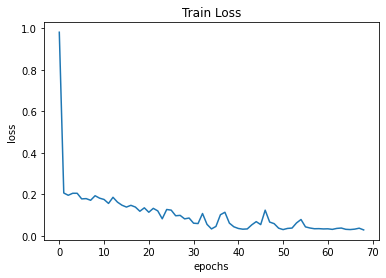

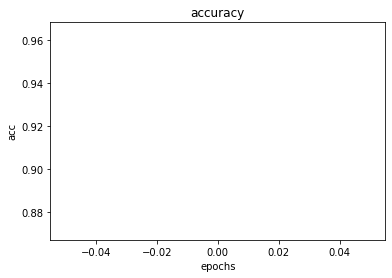

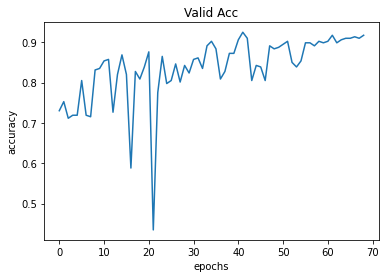

In [203]:
net = CNNX_R().to(device)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_fix_cut_r50_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 150 epoch

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0606_a_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 250 epoch

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## DRN 250 epoch ranger

In [ ]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_ranger_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## EfficientNet V3

In [ ]:
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0608_eff_.pth')
test_acc = test(net, test_loader, loss_fn)
EndTime = time.time()
print('Time Usage: ', str(datetime.timedelta(seconds=int(round(EndTime-StartTime)))))



plt.figure()
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(valid_acc)
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

plt.figure()
plt.plot(val_acc)
plt.title('Valid Acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Per patient WNL1

In [22]:
count = 1
net = CNNX1().to(device)
learning_rate = 0.0001
optimizer = Ranger(net.parameters())
loss_fn = Focal_Loss()
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_ranger_.pth')
print('test model ready')

testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/20402992/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/PE/04517051/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_dinamic(list(testing_data), transform = None)
print('testing set ready')
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)
test_acc = test(net, testing_loader, loss_fn)

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_0607_drn_ranger_.pth
set state called
test model ready
10 6
testing set ready

Test set: Average loss: 1.2755, Accuracy: 6/16 (38%), PE_acc: (6), noPE_acc: (0)



In [29]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/WNL/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

79 0


In [ ]:
net = CNNX1().to(device)
learning_rate = 0.0001
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
#optimizer = Ranger(net.parameters())

### DRN

In [30]:
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth')
testing_acc = test(net, testing_loader, loss_fn)

load /home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_dinamic_cut_drn_.pth
set state called

Test set: Average loss: 0.0279, Accuracy: 73/79 (92%), PE_acc: (0), noPE_acc: (73)



# Per patient no_PE

In [31]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/WNL/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/test/noPE/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

93 10


In [ ]:
 torch.cuda.empty_cache()

In [ ]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v0/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/CT_CLA/v1/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

NEW_dataset/20210604

In [ ]:
testing_0 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/WNL/*'))
testing_1 = list(glob.glob('/home/ubuntu/Andrew/lung_datatset/no_PE/*'))
testing_data, _, _ = get_data(testing_0, testing_1, 1)
Testing_Set = PE_transform(list(testing_data), transform = None)
testing_loader = DataLoader(Testing_Set, batch_size=test_bs, shuffle = False,
                      num_workers=8, pin_memory=True)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
loss_fn = Focal_Loss()

In [ ]:
#net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/CT_class_resbest_acc_A1_.pth')
#testing_acc = test(net, testing_loader, loss_fn)

net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_10.pth')
testing_acc = test(net, testing_loader, loss_fn)
'''
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_20.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_30.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_40.pth')
testing_acc = test(net, testing_loader, loss_fn)
net, _, _ = load_model(net, optimizer, '/home/ubuntu/Andrew/PE_research/log/savemodel/drn_50.pth')
testing_acc = test(net, testing_loader, loss_fn)
'''